In [1]:
import torch
from torchvision.models import alexnet
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import warnings
import os
import pdb
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import itertools
import pickle
import warnings
from scipy.optimize import fmin
from scipy.stats import norm
import random
import pdb
import matplotlib.colors as mcolors
import timm
import itertools
import pandas as pd
import dill
from scipy.optimize import curve_fit

warnings.filterwarnings("ignore")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def get_model(model_name):
    activations = []

    def get_activation(name):
        def hook(model, input, output):
            activations.append(output)
        return hook

    layers_to_extract = ['features.0', 'features.2', 'features.5', 'features.12', 'classifier.1', 'classifier.6']

    # load from checkpoint
    checkpoint = torch.load("checkpoints/alexnet_epoch_" + str(model_name) + ".pth", map_location=torch.device('cpu'))
    
    # load weights in - need to remove "module here" because of gpu parallelization (i think)
    state_dict = checkpoint['model_state_dict']
    new_state_dict = {key.replace("module.", ""): value for key, value in state_dict.items()}

    # Recreate the AlexNet model and load weights
    model = alexnet()
    model.load_state_dict(new_state_dict)
    model.eval()

    # Retrieve additional information
    epoch = checkpoint['epoch']
    INacc = checkpoint['accuracy']
    
    # Register hooks to capture the outputs of the selected layers
    for layer_name in layers_to_extract:
        layer = dict([*model.named_modules()])[layer_name]
        layer.register_forward_hook(get_activation(layer_name))
    return model, activations, layers_to_extract, INacc


def preprocess_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

def load_image(img_path, input_size):
    preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
    ])
    image = Image.open(img_path)
    image = preprocess(image)
    image = image.unsqueeze(0)  # Create a mini-batch as expected by the model
    return image

# define loss function to compute scaling values
def compute_loss(params, all_combinations, biggerDiff):
    psi = params[:11]
    sigma = params[11]
    
    # make a copy here of all the combinations
    all_combinations_copy = np.copy(all_combinations)
    all_combinations_copy = all_combinations_copy/10
    
    # replace with the psi values
    for interp_val in range(11):
        all_combinations_copy[all_combinations == interp_val] = psi[interp_val]

    # calculate the differences and probabilitys
    diffs = np.abs(all_combinations_copy[:, 0] - all_combinations_copy[:, 1]) - np.abs(all_combinations_copy[:, 2] - all_combinations_copy[:, 3])
    total_prob = 0
    for response_num in range(len(diffs)):
        if biggerDiff[response_num] == 1:
            prob_response = -np.log(norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
        elif biggerDiff[response_num] == 2:
            prob_response = -np.log(1-norm.cdf(diffs[response_num], 0, sigma))
            total_prob += prob_response
    return total_prob

# Generate all pairings of numbers from 0 to 10 without repeats
pairs = list(itertools.combinations(range(11), 2))

# Now generate all combinations of two pairs and convert to a matrix
all_combinations = np.array([a + b for a, b in itertools.combinations(pairs, 2)])

In [ ]:
#which epochs do you want to look at? define here as range
#model_names = range(20,21);

In [ ]:
# if you want to wipe everything and start over, uncomment these out.
#Psis = {};
#mldsSigmas = {};
#allSpecs = {};
#allINacc = {};

#loop through all model epochs (model names)
for model_name in model_names:
    print("epoch:" + str(model_name))
    activationLoss = 0
    fade = 0
    
    # Load the model, initialize the activation hooks, and get specs/imagenet accuracy
    model, activations, layers_to_extract, INacc = get_model(model_name)
    allINacc[model_name] = INacc
    
    # Name the textures, the interpolation values, and create empty dictionaries to store things
    #image1Names = ['acorns', 'grass', 'lemons', 'pebbles', 'petals', 'bees', 'iceCream', 'corn', 'guacamole', 'rubies', 'blueberries']
    #image2Names = ['redwood', 'leaves', 'bananas', 'granite', 'buttercream', 'pineapple', 'gooseFeathers', 'balloons', 'brainCoral', 'cherries', 'beads']
    image1Names = ['lemons',]
    image2Names = ['bananas',]
    interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    interpValues = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    interpNames = [f"{string1}_{string2}" for string1, string2 in zip(image1Names, image2Names)]
    allActivations = {}; allImages = {}; imageNames = []; imageIndex = 0;
    
    # Actually go through and extract all activations
    for interpName in interpNames:
        for interpValue in interpValues:
            img_path = os.path.join('out', interpName, '10x10', 
                    f"{image1Names[imageIndex]}_{interpValue}_{image2Names[imageIndex]}_10x10_pool4_smp1.png")
            imageName = f"{interpName}_{interpValue}"
            # Different name if doing activation loss images
            if activationLoss == 1:
                img_path = 'out_activations_bal/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_1x1' + '_pool4_smp1.png'
            if fade == 1:
                img_path = 'fades/' + image1Names[imageIndex] + '_' + str(interpValue) + '_' + image2Names[imageIndex] + '_pool4_smp1.png'
            #print(img_path)
            x = preprocess_image(img_path, 224)
            unprocessed_image = load_image(img_path, 224)
            
            # Reset activations
            activations.clear()
    
            # Forward pass through the model
            with torch.no_grad():
                model(x)
    
            # Save outputs
            allActivations[imageName] = [activation.numpy() for activation in activations]
            allImages[imageName] = unprocessed_image.squeeze(0).permute(1, 2, 0).numpy()  # Save the original image
            imageNames.append(imageName)
            
            # Add softmax as last layer and classification as final
            allActivations[imageName].append(scipy.special.softmax(allActivations[imageName][len(layers_to_extract)-1]))            
            softMaxProbs = scipy.special.softmax(allActivations[imageName][len(layers_to_extract)-1]);
            
        # Move on to next image
        imageIndex += 1


    ## now do the mlds
    # pick which layers you want to look at
    layers = range(0,len(layers_to_extract)+1)
    
    # init a figure
    fig = plt.figure(figsize=(15, 4*len(layers)))
    sub = 0;

    #create empty dicts to store psi values for each model
    Psis[model_name] = {}
    mldsSigmas[model_name] = {}

    #iterate through layers, doing mlds
    for layer in layers:
    
        # iterate through interpolations
        for interpPair in range(len(interpNames)):
            
            # make an empty list to keep track
            biggerDiff = [];
    
            # simulate the 2AFC decisions based on cosine dissimilarity between embeddings
            for pairings in all_combinations.astype(int):
                # add which interp number this is by adding amount of pairs you've iterated * num interp values
                pairings = tuple(x + interpPair*len(interpValues) for x in pairings)
                # get the index from all activations to the pairs
                im1 = pairings[0]; im2 = pairings[1]; im3 = pairings[2]; im4 = pairings[3];
                # calcuate the distances
                dist12 = scipy.spatial.distance.cosine(allActivations[imageNames[im1]][layer].flatten(), allActivations[imageNames[im2]][layer].flatten())
                dist34 = scipy.spatial.distance.cosine(allActivations[imageNames[im3]][layer].flatten(), allActivations[imageNames[im4]][layer].flatten())
                if dist12 > dist34:
                    biggerDiff.append(1)
                elif dist34 > dist12:
                    biggerDiff.append(2)
                else:
                    biggerDiff.append(0)
            
            
            # set up initial params
            psi = np.arange(0, 11)/10 #np.random.rand(11)#
            sigma = 0.2
            initial_params = np.concatenate((psi, [sigma]))
            
            # search for params
            optimal_params = fmin(compute_loss, initial_params, args=(all_combinations, biggerDiff));
            psi = optimal_params[:11]
            psi = psi - np.min(psi)
            psi = psi / np.max(psi)
    
            # save the fit parameters (psi and sigma values)
            Psis[model_name][(layer, interpPair)] = psi;
            mldsSigmas[model_name][(layer, interpPair)] = optimal_params[11];
            
            # plot it
            plt.subplot(len(layers),len(image1Names),interpPair+1+sub*len(image1Names))
            
            # iterate over interp_values
            for interp_value in range(11):
                im = interpPair * len(interpValues) + interp_value
                plt.imshow(allImages[imageNames[im]], extent=[(interp_value ) / 10 - 0.05, (interp_value) / 10 + 0.05, psi[interp_value] - 0.05, psi[interp_value] + 0.05])
           
            # set axis limits
            plt.xlim([-0.05, 1.05])
            plt.ylim([-0.05, 1.05])
            plt.plot([0, 1], [0, 1], 'r')
    
        sub += 1        
    # show the plot
    fig.supylabel('Perceptual distance value')
    fig.supxlabel('Synthesized interpolation value')
    

In [72]:
#pick which model you want to look at
cornet = 1
efficientnet = 0

if cornet:
    #load
    dill.load_session('1125cornet.db')
    #name your layers
    layerNames = ['V1', 'V2', 'V4', 'IT', 'Decoder']
    #multiply imagenet accuracy by 100
    for epoch in range(0,len(allINacc)):
        allINacc[epoch] *= 100
elif efficientnet:
    #load
    dill.load_session('1122alexnet.db')
    #name layers
    layerNames = ['0', '1', '2', '3', '4', 'FC', 'Softmax'] 
    
    
#set up matplotlib
import sys
sys.path.append('/Users/gru/latent_matching/src')
from visualization import utils
utils.setup_matplotlib()
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams['font.family'] = 'Helvetica'
plt.rcParams['pdf.fonttype'] = 3

In [4]:
##load in psychophysics data and calculate MSE
PsychophysicsData = scipy.io.loadmat(os.path.expanduser('~/Desktop/interp/texMldsGroupData3.mat'),  struct_as_record=False, squeeze_me=True)
PPdata = PsychophysicsData['data']

#0acorns, 1grass, 2lemons, 3pebbles, 4petals, 5bees, 6feathers, 7corn, 8guac, 9cherries, 10blueberries
#texIndices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
texIndices = [0, 1, 2, 4, 5, 7, 9, 10] # TAKE OUT GRANITE/PEBBLES and feathers/icecream
#texIndices = [5, 7, 8, 9, 10] #test

## calculate the human performance floor
humanMSEindividualTex = {}

for tex in texIndices:
    
    numSubjects = 0
    HumanHumanDifferences = 0;
    
    for subject1 in range(0, len(PPdata.SIDnums)):
        for subject2 in range(0, len(PPdata.SIDnums)):
            if subject1 != subject2:
                if (len(PPdata.psi[subject1]) > tex) & (len(PPdata.psi[subject2]) > tex):
                    if (len(PPdata.psi[subject1][tex]) > 0) & (len(PPdata.psi[subject2][tex]) > 0): 
                        HumanHumanDifferences += np.sum((PPdata.psi[subject1][tex] - PPdata.psi[subject2][tex])**2)
                        numSubjects+=1
                        
    if numSubjects != 0:
        humanMSEindividualTex[tex] = HumanHumanDifferences / numSubjects
    else:
        humanMSEindividualTex[tex] = 'NaN'
        
## calculate the human performance on a model that just predicts 0:.1:1
humanNullMSEindividualTex = {}

for tex in texIndices:
    
    numSubjects = 0
    HumanNullDifferences = 0;
    
    for subject in range(0, len(PPdata.SIDnums)): 
        if (len(PPdata.psi[subject]) > tex):
            if (len(PPdata.psi[subject][tex]) > 0): 
                HumanNullDifferences += np.sum((PPdata.psi[subject][tex] - interpValues)**2)
                numSubjects+=1
                        
    if numSubjects != 0:
        humanNullMSEindividualTex[tex] = HumanNullDifferences / numSubjects
    else:
        humanNullMSEindividualTex[tex] = 'NaN'

In [5]:
## calculate the differences between the neural network psi values and the human psychophysics psi values

# choose your fighter - mean squared error between psi values or cosine dissimilarity. I default MSE
MSEunits = 'squared error'
#MSEunits = 'cosine'

# initialize some colors, empty dict, indices
MSE = {}

# MSE case
if MSEunits == 'squared error':
    for model_name in model_names:
        MSE[model_name] = np.zeros(len(layers))

        for layerIndex in range(0,len(layers)):
            MSE[model_name][layer] = 0;
            for tex in texIndices:
                #you want to count up, for each texture, total error and number of subjects
                numSubs = 0;
                texError = 0;
                for subject in range(len(PPdata.SIDnums)):
                    if (len(PPdata.psi[subject]) > tex):
                        if (len(PPdata.psi[subject][tex]) > 0):
                            #add up mean squared error from y=x for each subject
                            HumanNNdifferences = Psis[model_name][(layers[layerIndex],tex)] - PPdata.psi[subject][tex]
                            texError += np.sum(HumanNNdifferences**2)
                            numSubs += 1
                #add error divided by number of subs            
                MSE[model_name][layerIndex] += texError/numSubs


    yUnits = 'MSE between human and layer geometry'

# Cosine case
elif MSEunits == 'cosine':
    for model_name in model_names:
        MSE[model_name] = np.zeros(len(layers))

        for layerIndex in range(0,len(layers)):
            MSE[model_name][layer] = 0;
            for tex in texIndices:
                for subject in range(len(PPdata.SIDnums)):
                    if (len(PPdata.psi[subject]) > tex):
                        if (len(PPdata.psi[subject][tex]) > 0):        
                            #add up cosine distances
                            MSE[model_name][layerIndex] += scipy.spatial.distance.cosine(Psis[model_name][(layers[layerIndex],tex)], PPdata.psi[subject][tex])

    yUnits = 'Cosine distance between Human/NN psi'
    

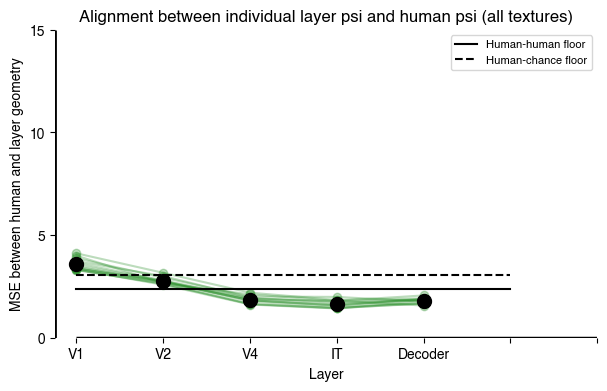

In [27]:
## plot all models together
plt.figure(figsize=[7,4])
ax = plt.gca();

for model_name in model_names:
    plt.plot(range(0,len(MSE[model_name])), MSE[model_name], alpha = .3, color = 'forestgreen')
    plt.scatter(range(0,len(MSE[model_name])), MSE[model_name], alpha = .3, color = 'forestgreen')

#plt.xticks(layers, layers_to_extract)
plt.xlabel('Layer', fontsize = 10)
plt.ylabel(yUnits, fontsize = 10)
plt.title('Alignment between individual layer psi and human psi (all textures)', fontsize=12)
plt.ylim([0,15])

# calculate and plot the averages
allMSE = np.zeros([len(model_names), len(layers)])
for model in range(0, len(model_names)):
    allMSE[model,:] = MSE[model_names[model]]

# plot the errorbars
for layer in range(0,len(layers)):
    plt.errorbar(layer, np.mean(allMSE[:,layer]), fmt = 'o',
                 yerr = np.std(allMSE[:,layer]),#/np.sqrt(len(model_names)),
                 color = 'k', markersize = 10,capsize = 0)
    
#plot human-human error
plt.plot([0,len(MSE[model_name])], [sum(humanMSEindividualTex.values()), sum(humanMSEindividualTex.values())], 'black', linestyle='solid', label='Human-human floor')
plt.plot([0,len(MSE[model_name])], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())], 'black', linestyle='dashed', label='Human-chance floor')

plt.legend(fontsize=8)

plt.xticks(range(0,len(MSE[model_name])), layerNames, fontsize = 10);

utils.draw_publish_axis(ax, xrange = [0, 7], yrange = [0, 15], xticks = [0,1,2,3,4,5,6], yticks = [0, 5, 10, 15])

plt.show()

#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig1.svg'), format = 'svg', bbox_inches='tight')

In [29]:
scipy.stats.ttest_rel(allMSE[:,3], allMSE[:,4], alternative='less')

Ttest_relResult(statistic=-3.0079505964050126, pvalue=0.005452191527525341)

## ** result? **
geometry matches worse in the fully connected classification layer than in the layer immediately preceeding. This is the case for the trained networks, but not necessarily for the untrained ones. can seperate out by training epochs.

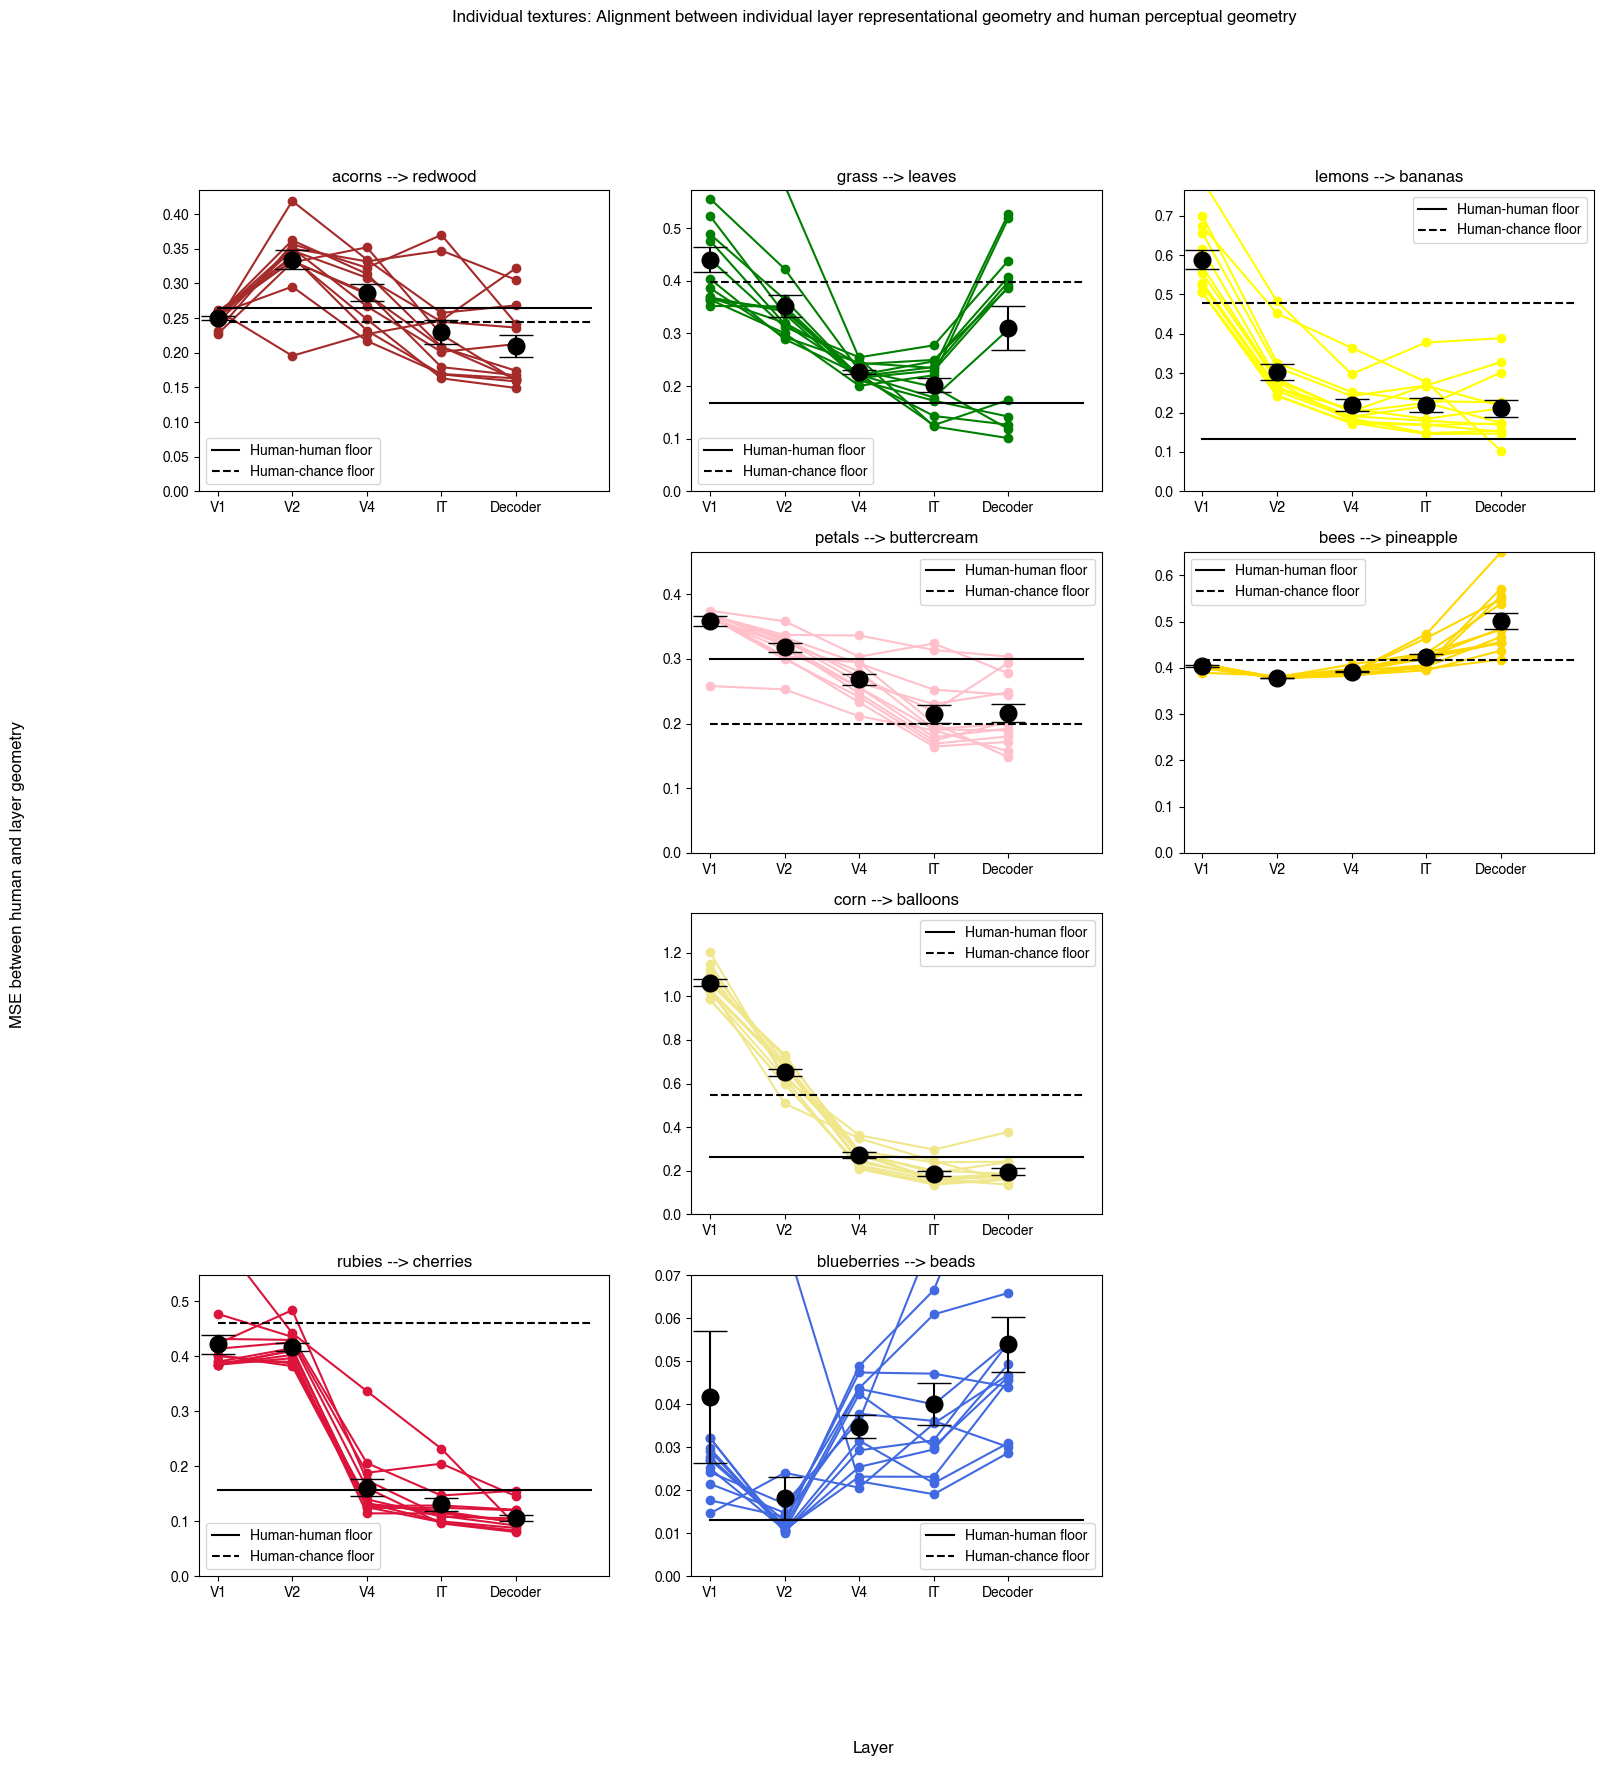

In [32]:
#plot everything together, colored by interpolation
colors = ['brown','green','yellow','grey','pink','gold','antiquewhite','khaki','limegreen','crimson','royalblue','g']
fig = plt.figure(figsize=(18, 18))

for tex in texIndices:
    MSEindividualTex = {}
    plt.subplot(4,3,tex+1)
    
    for model_name in model_names:
        MSEindividualTex[model_name] = np.zeros(len(layers))

        for layerIndex in range(0,len(layers)):
            MSEindividualTex[model_name][layer] = 0;
            texError = 0
            numSubs = 0
            for subject in range(len(PPdata.SIDnums)):
                if (len(PPdata.psi[subject]) > tex):
                    if (len(PPdata.psi[subject][tex]) > 0):              
                        HumanNNdifferences = Psis[model_name][(layers[layerIndex],tex)] - PPdata.psi[subject][tex]
                        texError += np.sum(HumanNNdifferences**2)
                        numSubs += 1
                        
            MSEindividualTex[model_name][layerIndex] += texError / numSubs

    for model_name in model_names:
        plt.plot(range(0,len(MSE[model_name])), MSEindividualTex[model_name], label='_nolegend_', color = colors[tex])
        plt.scatter(range(0,len(MSE[model_name])), MSEindividualTex[model_name], color = colors[tex])
    
    plt.title(image1Names[tex] + ' --> ' + image2Names[tex])


    # calculate and plot the averages
    allMSEindividualTex = np.zeros([len(model_names), len(layers)])
    for model in range(0, len(model_names)):
        allMSEindividualTex[model,:] = MSEindividualTex[model_names[model]]
        
    # paired ttest between classification layer and right before
    #print(scipy.stats.ttest_rel(allMSEindividualTex[:,4], allMSEindividualTex[:,5]))


    # plot the errorbars
    for layer in range(0,len(layers)):
        plt.errorbar(layer, np.mean(allMSEindividualTex[:,layer]), fmt = 'o',
                     yerr = np.std(allMSEindividualTex[:,layer])/np.sqrt(len(model_names)),
                     color = 'k', markersize = 12,capsize = 12)
    
    # label layers and set ylim
    plt.ylim([min(np.mean(allMSEindividualTex[:,:],0))*0.7, max(np.mean(allMSEindividualTex[:,:],0))*1.3])
    plt.ylim([0, max(np.mean(allMSEindividualTex[:,:],0))*1.3])
    plt.xticks(range(0,len(MSE[model_name])), layerNames);
    plt.plot([0,len(MSE[model_name])], [humanMSEindividualTex[tex], humanMSEindividualTex[tex]], 'black', label='Human-human floor')
    plt.plot([0,len(MSE[model_name])], [humanNullMSEindividualTex[tex], humanNullMSEindividualTex[tex]], 'black', linestyle='dashed', label='Human-chance floor')
    plt.legend();
    
# Label the whole thing
fig.supxlabel('Layer')
fig.supylabel(yUnits)
plt.suptitle('Individual textures: Alignment between individual layer representational geometry and human perceptual geometry');
plt.show()



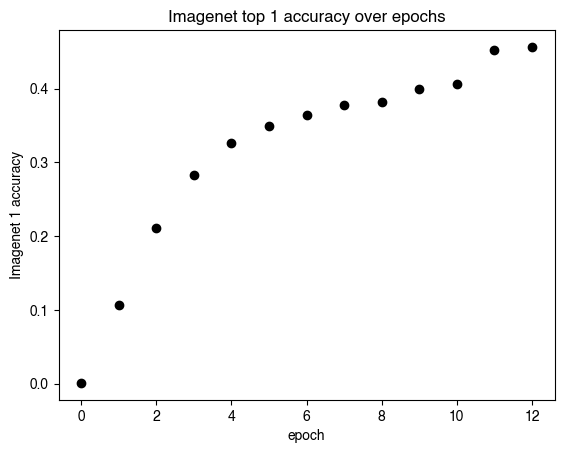

In [33]:
plt.figure()
for epoch in model_names:
    plt.scatter(epoch, allINacc[epoch], color = "black")
    
plt.xlabel('epoch'); plt.ylabel('Imagenet 1 accuracy')
plt.title('Imagenet top 1 accuracy over epochs')
plt.show()

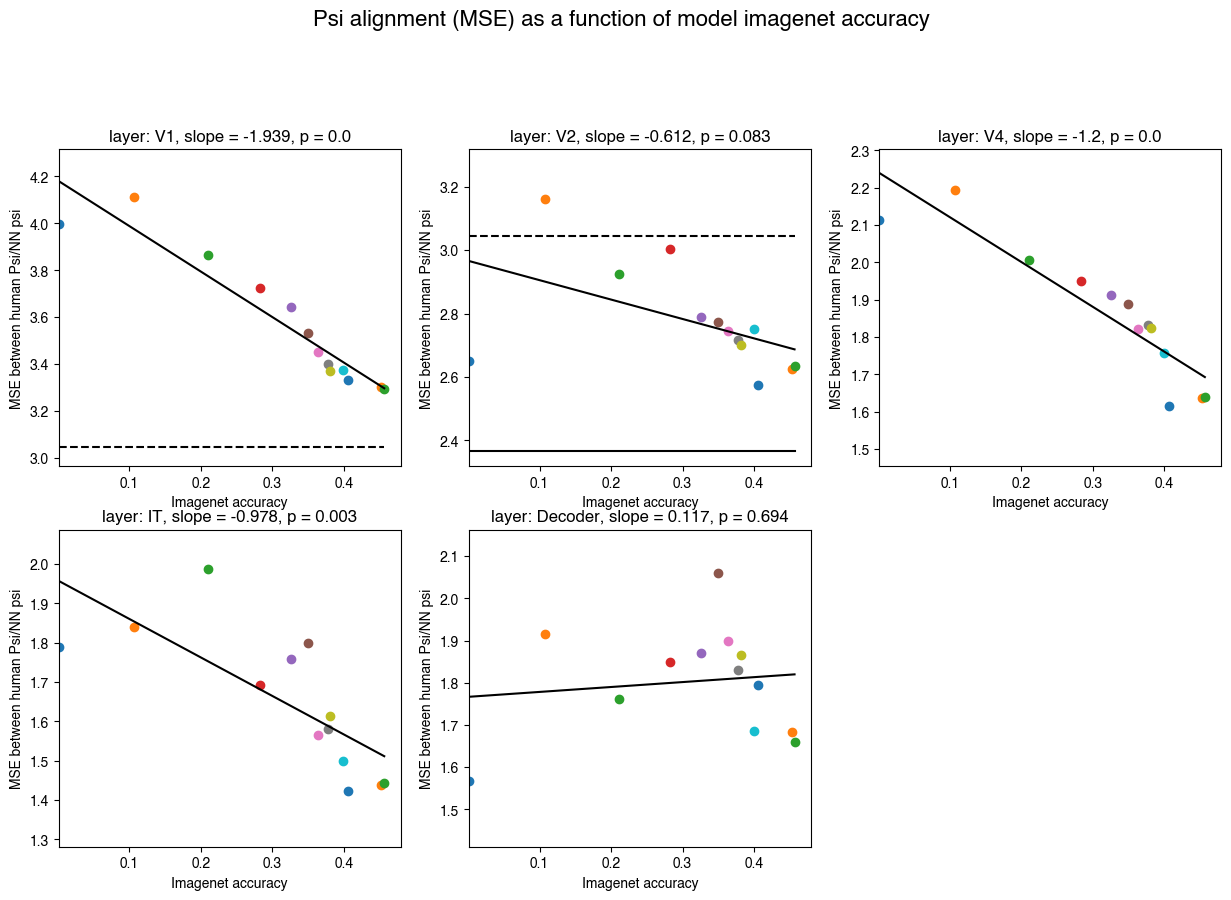

In [34]:
plt.figure(figsize = (15,14))
#plot for each layer
for layer in layers:
    plt.subplot(3,3,layer+1)
    x = []
    y = []
    #plot every model MSE and imagenet accuracy
    for i in range(0,len(model_names)):
        #get values
        INperformance = float(allINacc[model_names[i]]);
        modelLayerMSE = allMSE[i][layer]
        #plot and save into array
        plt.scatter(INperformance, modelLayerMSE)
        x.append(INperformance), y.append(modelLayerMSE)
        
    #get usable values, set limits    
    x, y = zip(*[(xi, yi) for xi, yi in zip(x, y) if isinstance(xi, (int, float)) and not np.isnan(xi)]) 
    plt.xlim(min(x)*.95, max(x)*1.05)
    plt.ylim([min(y)*.90, max(y)*1.05])
    plt.xlabel('Imagenet accuracy')
    plt.ylabel('MSE between human Psi/NN psi')
    
    # plot regression line, get pvalue
    plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed', label='Human-chance floor')
    plt.plot([np.min(x),np.max(x)], [sum(humanMSEindividualTex.values()), sum(humanMSEindividualTex.values())], 'black', linestyle='solid', label='Human-chance floor')
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    
    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
    
plt.suptitle('Psi alignment (MSE) as a function of model imagenet accuracy', fontsize=16);
plt.show()

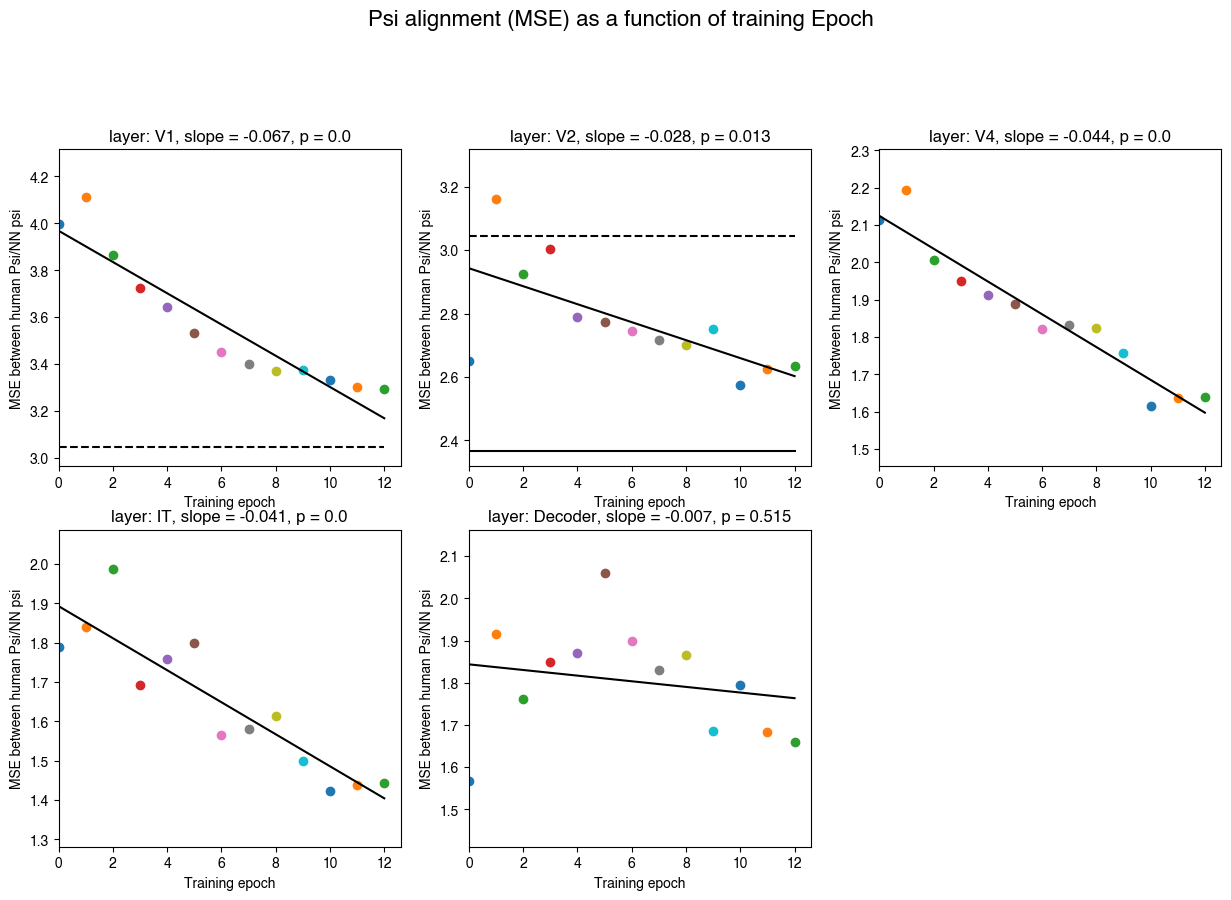

In [35]:
plt.figure(figsize = (15,14))
#plot for each layer
for layer in layers:
    plt.subplot(3,3,layer+1)
    x = []
    y = []
    #plot every model MSE and imagenet accuracy
    for i in range(0,len(model_names)):
        #get values
        INperformance = float(model_names[i]);
        modelLayerMSE = allMSE[i][layer]
        #plot and save into array
        plt.scatter(INperformance, modelLayerMSE)
        x.append(INperformance), y.append(modelLayerMSE)
        
    #get usable values, set limits    
    x, y = zip(*[(xi, yi) for xi, yi in zip(x, y) if isinstance(xi, (int, float)) and not np.isnan(xi)]) 
    plt.xlim(min(x)*.95, max(x)*1.05)
    plt.ylim([min(y)*.90, max(y)*1.05])
    plt.xlabel('Training epoch')
    plt.ylabel('MSE between human Psi/NN psi')
    
    # plot regression line, get pvalue
    plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed', label='Human-chance floor')
    plt.plot([np.min(x),np.max(x)], [sum(humanMSEindividualTex.values()), sum(humanMSEindividualTex.values())], 'black', linestyle='solid', label='Human-chance floor')
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    
    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
    
plt.suptitle('Psi alignment (MSE) as a function of training Epoch', fontsize=16);
plt.show()

## ** result? **
seems like "better alignment" is driven mostly by PSE alignment (capturing the bias) rather than better capturing the steepness of the transition (sigma).

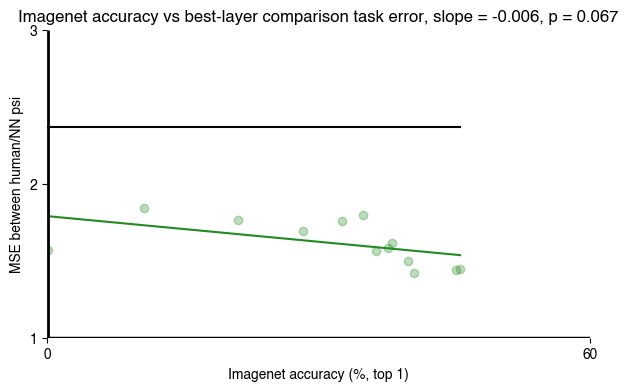

In [47]:
plt.figure(figsize=[7,4])
ax = plt.gca()
#plot for each layer
x = []
y = []
#plot every model MSE and imagenet accuracy
for i in range(0,len(model_names)):
    #get values
    INperformance = allINacc[model_names[i]];
    modelLayerMSE = min(allMSE[i])
    if INperformance != 'NaN':
        #plot and save into array
        plt.scatter(INperformance, modelLayerMSE, color = 'forestgreen', alpha = .3)
        x.append(INperformance), y.append(modelLayerMSE)

#get usable values, set limits    
plt.xlim(min(x)*.95, max(x)*1.05)
plt.ylim([1, 3])
plt.xlabel('Imagenet accuracy (%, top 1)', fontsize = 10)
plt.ylabel('MSE between human/NN psi', fontsize = 10)

#plot the best fit line
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='forestgreen');
plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed');
plt.plot([np.min(x),np.max(x)], [sum(humanMSEindividualTex.values()), sum(humanMSEindividualTex.values())], 'black', linestyle='solid', label='Human-human error')
res = scipy.stats.linregress(x,y)
plt.title('Imagenet accuracy vs best-layer comparison task error' + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)), fontsize=12);
#plt.legend(fontsize = 8)

utils.draw_publish_axis(ax, xrange = [0, 60], yrange = [1, 3], xticks = [0, 60], yticks = [1, 2, 3])
plt.show()

#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig2.svg'), format = 'svg')

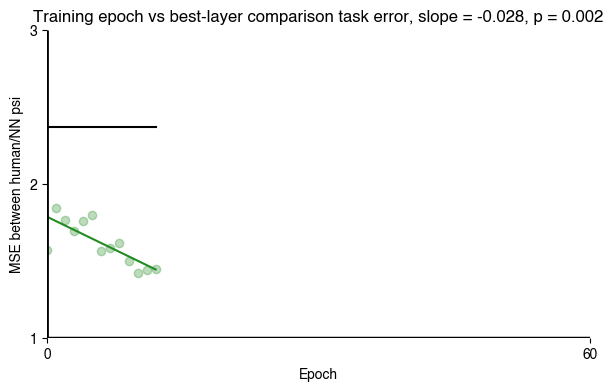

In [48]:
plt.figure(figsize=[7,4])
ax = plt.gca()
#plot for each layer
x = []
y = []
#plot every model MSE and imagenet accuracy
for i in range(0,len(model_names)):
    #get values
    INperformance = model_names[i];
    modelLayerMSE = min(allMSE[i])
    if INperformance != 'NaN':
        #plot and save into array
        plt.scatter(INperformance, modelLayerMSE, color = 'forestgreen', alpha = .3)
        x.append(INperformance), y.append(modelLayerMSE)

#get usable values, set limits    
plt.xlim(min(x)*.95, max(x)*1.05)
plt.ylim([1, 3])
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('MSE between human/NN psi', fontsize = 10)

#plot the best fit line
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='forestgreen');
plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed');
plt.plot([np.min(x),np.max(x)], [sum(humanMSEindividualTex.values()), sum(humanMSEindividualTex.values())], 'black', linestyle='solid', label='Human-human error')
res = scipy.stats.linregress(x,y)
plt.title('Training epoch vs best-layer comparison task error' + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)), fontsize=12);
#plt.legend(fontsize = 8)

utils.draw_publish_axis(ax, xrange = [0, 60], yrange = [1, 3], xticks = [0, 60], yticks = [1, 2, 3])
plt.show()

#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig2.svg'), format = 'svg')

## Let's switch over to PSEs now. Before, we were comparing the actual distance values. These can be a little noisy, so instead, now let's compare the PSEs of the cumulative gaussian functions fit to the psi values. We can do individual textures here - for each layer, we calculate the correlation between the PSEs of all the texture interpolations found by humans vs found by the neural networks.

In [49]:
## fit cumulative gaussian functions to the neural network data
NNmus = {}; NNsigmas = {};
for model_name in model_names:
    
    # init empty arrays
    #NNmus[model_name] = np.zeros(len(layers)); NNsigmas[model_name] = np.zeros(len(layers))
    NNmus[model_name] = np.zeros((len(layers), max(texIndices)+1))
    NNsigmas[model_name] = np.zeros((len(layers), max(texIndices)+1))
    
    # calc cumulative gaussian for each tex
    for layer in layers:
        
        # calc each layer
        for tex in texIndices:
            lower_bounds = [0, 0]
            upper_bounds = [1, 5]
            [mu, sigma] = curve_fit(norm.cdf, interpValues, Psis[model_name][layer, tex], p0=[.5,1], bounds=(lower_bounds, upper_bounds))[0]
            #pdb.set_trace()
            NNmus[model_name][layer, tex] = mu;
            NNsigmas[model_name][layer, tex] = sigma;

In [51]:
## calculate the differences between the neural network psi values and the human psychophysics psi values

# initialize some colors, empty dict, indices
corrs = {}

# MSE case

for model_name in model_names:
    corrs[model_name] = np.zeros(len(layers))

    for layerIndex in range(0,len(layers)):
        NNmuTemp = [];
        SubMuTemp = []
        for tex in texIndices:
            #you want to count up, for each texture, total error and number of subjects
            numSubs = 0;
            for subject in range(len(PPdata.SIDnums)):
                if (len(PPdata.psi[subject]) > tex):
                    if (len(PPdata.psi[subject][tex]) > 0):
                        #add up mean squared error from y=x for each subject
                        NNmuTemp.append(NNmus[model_name][layerIndex, tex])
                        SubMuTemp.append(PPdata.PSE[subject][tex])
                        numSubs += 1
            #add error divided by number of subs            
        #corrs[model_name][layerIndex] = np.corrcoef(NNmuTemp, SubMuTemp)[0,1]; #take correlations- i think this is wrong
        corrs[model_name][layerIndex] = np.mean(np.subtract(NNmuTemp, SubMuTemp)**2) # take mse

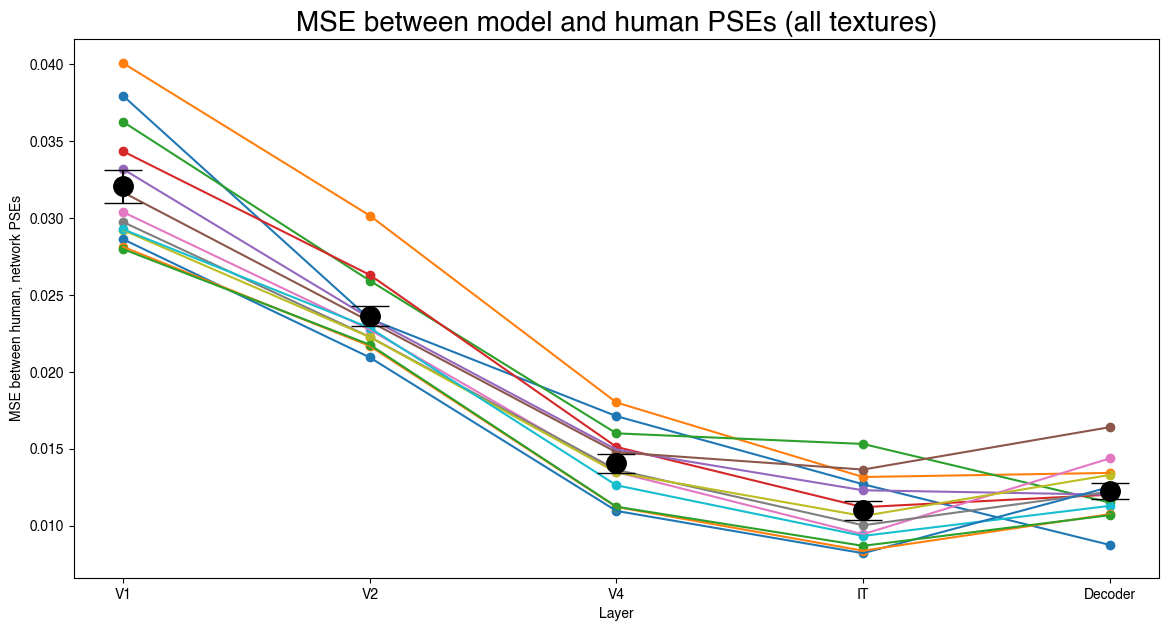

In [54]:
## plot all models together
fig = plt.figure(figsize=(14, 7))

for model_name in model_names:
    plt.plot(range(0,len(MSE[model_name])), corrs[model_name], label = model_name)
    plt.scatter(range(0,len(MSE[model_name])), corrs[model_name])

#plt.xticks(layers, layers_to_extract)
plt.xlabel('Layer')
plt.ylabel('MSE between human, network PSEs')
plt.title('MSE between model and human PSEs (all textures)', fontsize=20)
#plt.legend(prop={'size': 5})

# calculate and plot the averages
allCorrs = np.zeros([len(model_names), len(layers)])
for model in range(0, len(model_names)):
    allCorrs[model,:] = corrs[model_names[model]]

# plot the errorbars
for layer in range(0,len(layers)):
    plt.errorbar(layer, np.mean(allCorrs[:,layer]), fmt = 'o',
                 yerr = np.std(allCorrs[:,layer])/np.sqrt(len(model_names)),
                 color = 'k', markersize = 14,capsize = 14)
    
#plt.ylim([min(np.mean(allCorrs[:,:],0))*1.3, max(np.mean(allCorrs[:,:],0))*1.3])
plt.xticks(range(0,len(MSE[model_name])), layerNames);
plt.show()

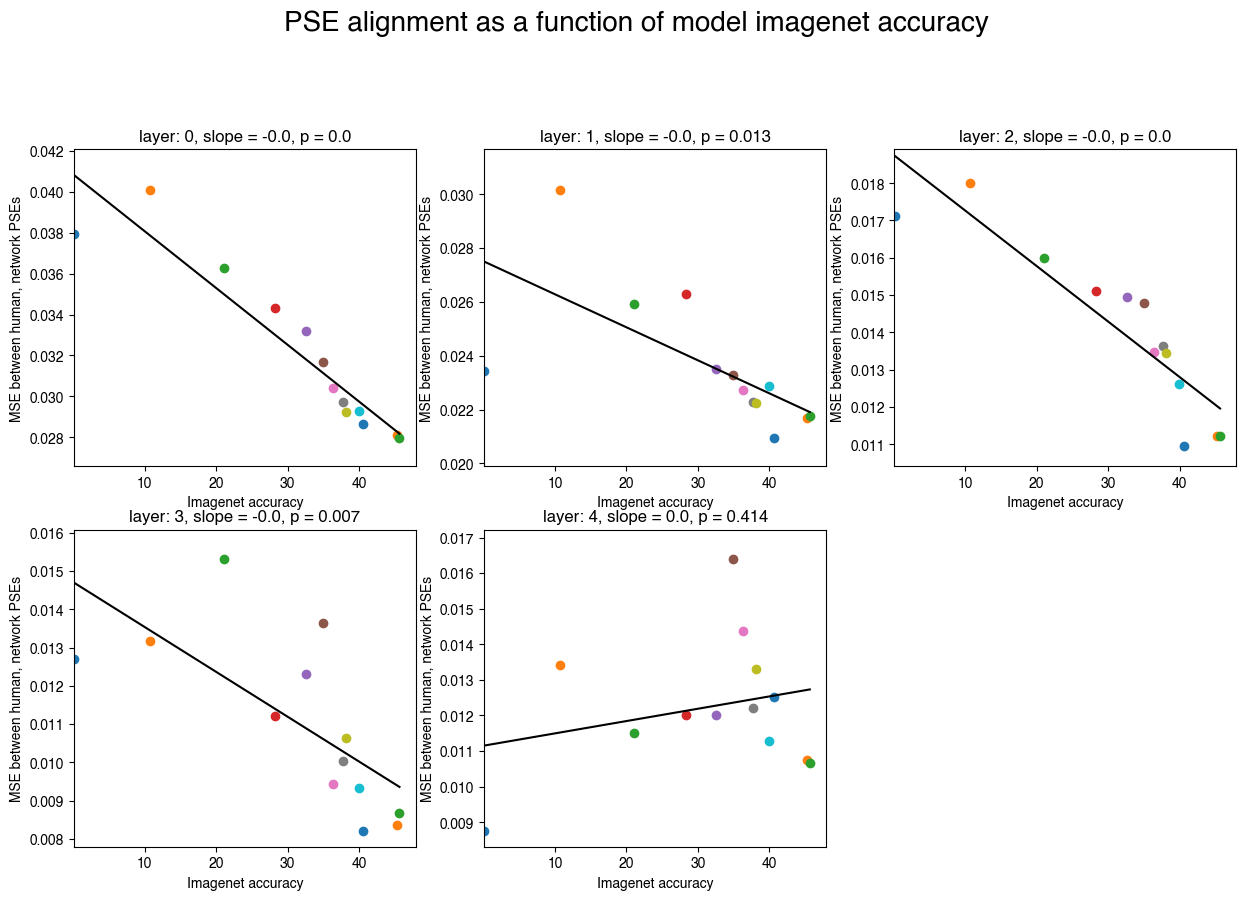

In [55]:
plt.figure(figsize = (15,14))
#plot for each layer
for layer in layers:
    plt.subplot(3,3,layer+1)
    x = []
    y = []
    #plot every model corr and imagenet accuracy
    for i in range(0,len(model_names)):
        #get values
        INperformance = allINacc[model_names[i]];
        modelLayerCorr = allCorrs[i][layer]
        if INperformance != 'NaN':
        #plot and save into array
            plt.scatter(INperformance, modelLayerCorr)
            x.append(INperformance), y.append(modelLayerCorr)
        
    #get usable values, set limits    
    plt.xlim(min(x)*.95, max(x)*1.05)
    plt.ylim([min(y)*.95, max(y)*1.05])
    plt.xlabel('Imagenet accuracy')
    plt.ylabel('MSE between human, network PSEs')
    
    # plot regression line, get pvalue
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    
    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
    
plt.suptitle('PSE alignment as a function of model imagenet accuracy', fontsize=20);
plt.show()

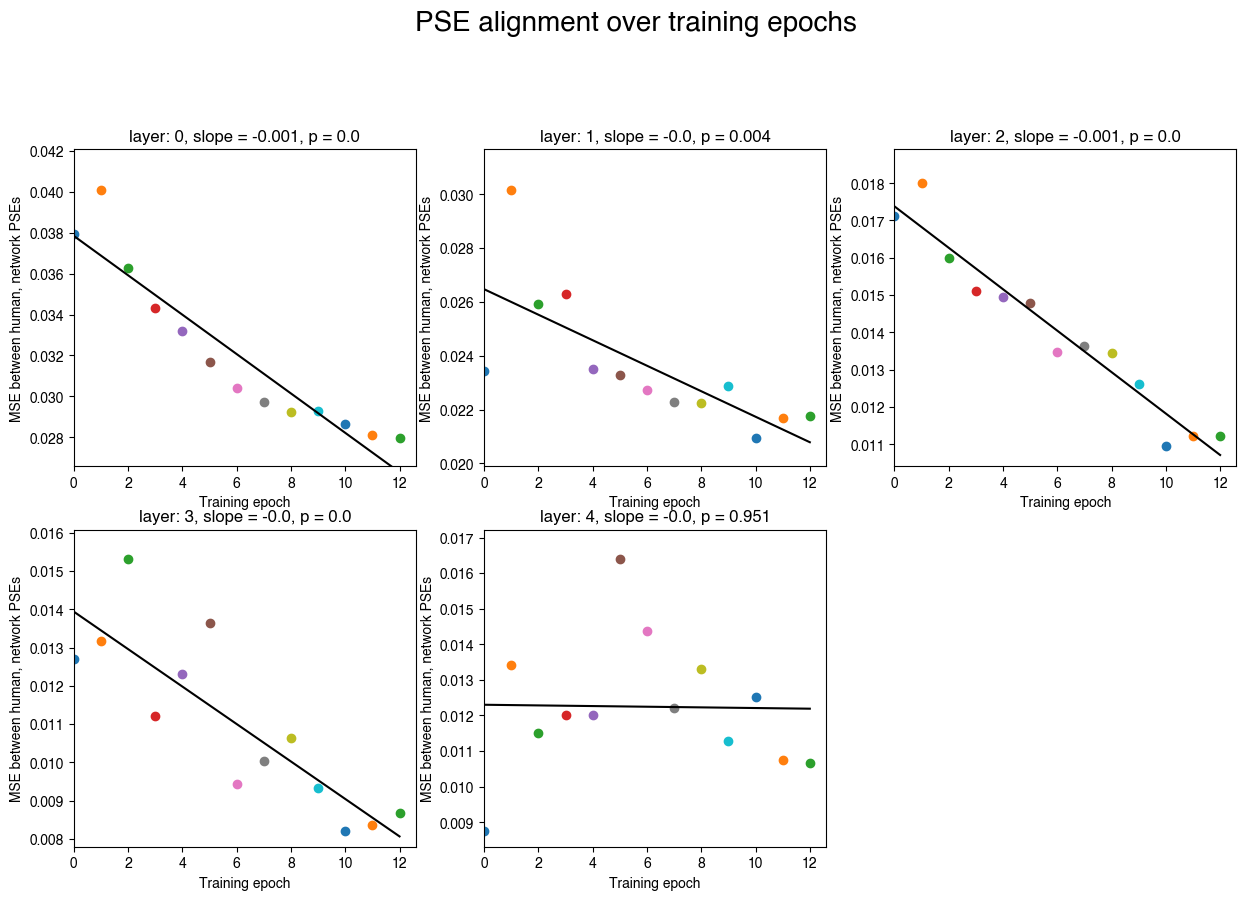

In [56]:
plt.figure(figsize = (15,14))
layerNames = ['0', '1', '2', '3', '4', 'fc', 'Softmax']
#plot for each layer
for layer in layers:
    plt.subplot(3,3,layer+1)
    x = []
    y = []
    #plot every model corr and imagenet accuracy
    for i in range(0,len(model_names)):
        #get values
        INperformance = model_names[i];
        modelLayerCorr = allCorrs[i][layer]
        if INperformance != 'NaN':
        #plot and save into array
            plt.scatter(INperformance, modelLayerCorr)
            x.append(INperformance), y.append(modelLayerCorr)
        
    #get usable values, set limits    
    plt.xlim(min(x)*.95, max(x)*1.05)
    plt.ylim([min(y)*.95, max(y)*1.05])
    plt.xlabel('Training epoch')
    plt.ylabel('MSE between human, network PSEs')
    
    # plot regression line, get pvalue
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    
    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
    
plt.suptitle('PSE alignment over training epochs', fontsize=20);
plt.show()

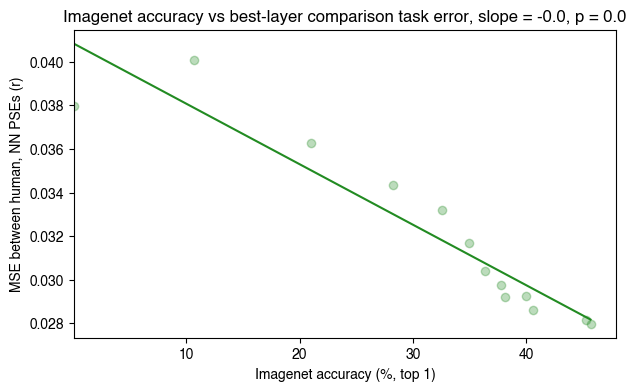

In [57]:
plt.figure(figsize = (7,4))
ax = plt.gca()
#plot for each layer
x = []
y = []
#plot every model corr and imagenet accuracy
for i in range(0,len(model_names)):
    #get values
    INperformance = allINacc[model_names[i]];
    modelLayerCorr = max(allCorrs[i])
    if INperformance != 'NaN':
        #plot and save into array
        plt.scatter(INperformance, modelLayerCorr, color = 'forestgreen', alpha = .3)
        x.append(INperformance), y.append(modelLayerCorr)

#get usable values, set limits    
plt.xlim(min(x)*.95, max(x)*1.05)
#plt.ylim([min(y)*.90, max(y)*1.05])
plt.xlabel('Imagenet accuracy (%, top 1)',fontsize=10)
plt.ylabel('MSE between human, NN PSEs (r)', fontsize=10)
plt.title('Imagenet accuracy vs best-layer comparison PSE error', fontsize=12)

#plot the best fit line
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='forestgreen');
#plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed', label='Human-chance floor');
res = scipy.stats.linregress(x,y);
plt.title('Imagenet accuracy vs best-layer comparison task error' + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)));


#utils.draw_publish_axis(ax, xrange = [0, 50], yrange = [.6, .95], xticks = [0, 50], yticks = [.6, .775, .95])
plt.show()

#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig3.svg'), format = 'svg')

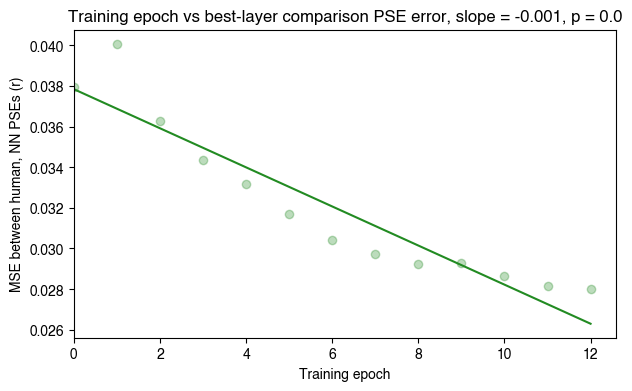

In [58]:
plt.figure(figsize = (7,4))
ax = plt.gca()
#plot for each layer
x = []
y = []
#plot every model corr and imagenet accuracy
for i in range(0,len(model_names)):
    #get values
    INperformance = model_names[i];
    modelLayerCorr = max(allCorrs[i])
    if INperformance != 'NaN':
        #plot and save into array
        plt.scatter(INperformance, modelLayerCorr, color = 'forestgreen', alpha = .3)
        x.append(INperformance), y.append(modelLayerCorr)

#get usable values, set limits    
plt.xlim(min(x)*.95, max(x)*1.05)
#plt.ylim([min(y)*.90, max(y)*1.05])
plt.xlabel('Training epoch',fontsize=10)
plt.ylabel('MSE between human, NN PSEs (r)', fontsize=10)

#plot the best fit line
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='forestgreen');
#plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed', label='Human-chance floor');
res = scipy.stats.linregress(x,y);
plt.title('Training epoch vs best-layer comparison PSE error' + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)));


#utils.draw_publish_axis(ax, xrange = [0, 50], yrange = [.6, .95], xticks = [0, 50], yticks = [.6, .775, .95])
plt.show()

#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig3.svg'), format = 'svg')

## Let's do the same comparison, but with the sigmas. How well does each layer match the sigmas of the cumulative gaussian function fit to the human perceptual distasnce values?


In [59]:
## calculate the differences between the neural network psi values and the human psychophysics psi values

# initialize some colors, empty dict, indices
corrs = {}

# MSE case

for model_name in model_names:
    corrs[model_name] = np.zeros(len(layers))

    for layerIndex in range(0,len(layers)):
        NNmuTemp = [];
        SubMuTemp = []
        for tex in texIndices:
            #you want to count up, for each texture, total error and number of subjects
            numSubs = 0;
            for subject in range(len(PPdata.SIDnums)):
                if (len(PPdata.psi[subject]) > tex):
                    if (len(PPdata.psi[subject][tex]) > 0):
                        #add up mean squared error from y=x for each subject
                        NNmuTemp.append(NNsigmas[model_name][layerIndex, tex])
                        SubMuTemp.append(PPdata.gaussSigma[subject][tex])
                        numSubs += 1
            #add error divided by number of subs            
        #corrs[model_name][layerIndex] = np.corrcoef(NNmuTemp, SubMuTemp)[0,1];
        corrs[model_name][layerIndex] = np.mean(np.subtract(NNmuTemp, SubMuTemp)**2) # take mse


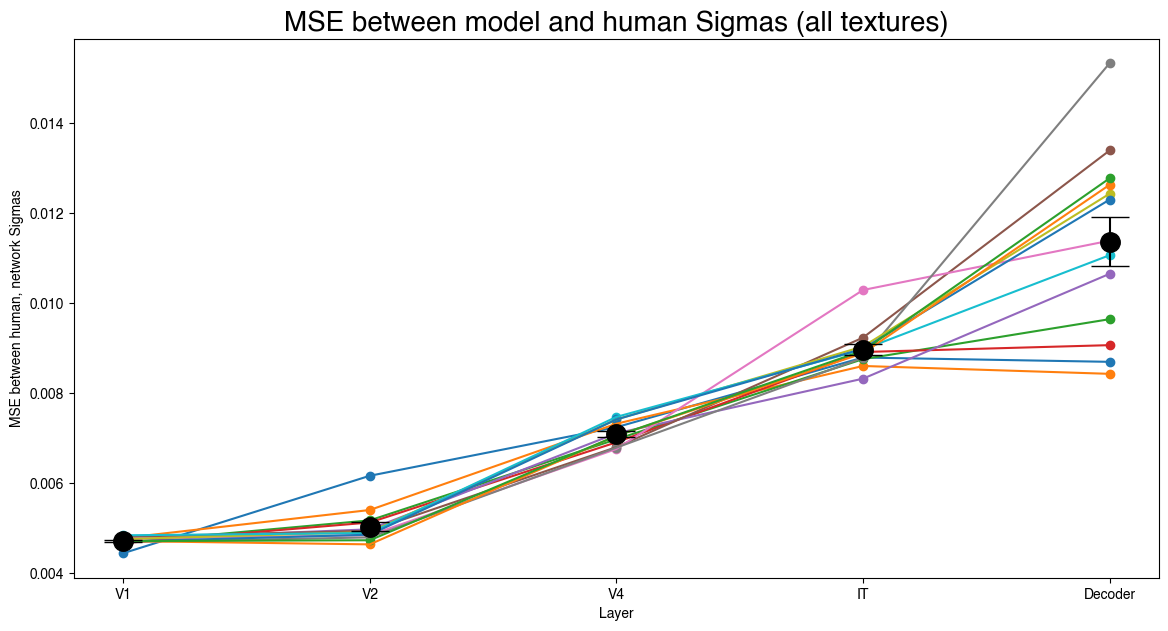

In [65]:
## plot all models together
fig = plt.figure(figsize=(14, 7))

for model_name in model_names:
    plt.plot(range(0,len(MSE[model_name])), corrs[model_name], label = model_name)
    plt.scatter(range(0,len(MSE[model_name])), corrs[model_name])

#plt.xticks(layers, layers_to_extract)
plt.xlabel('Layer')
plt.ylabel('MSE between human, network Sigmas')
plt.title('MSE between model and human Sigmas (all textures)', fontsize=20)

# calculate and plot the averages
allCorrs = np.zeros([len(model_names), len(layers)])
for model in range(0, len(model_names)):
    allCorrs[model,:] = corrs[model_names[model]]

# plot the errorbars
for layer in range(0,len(layers)):
    plt.errorbar(layer, np.mean(allCorrs[:,layer]), fmt = 'o',
                 yerr = np.std(allCorrs[:,layer])/np.sqrt(len(model_names)),
                 color = 'k', markersize = 14,capsize = 14)
    
#plt.ylim([-1, 1])
plt.xticks(range(0,len(MSE[model_name])), layerNames);
plt.show()

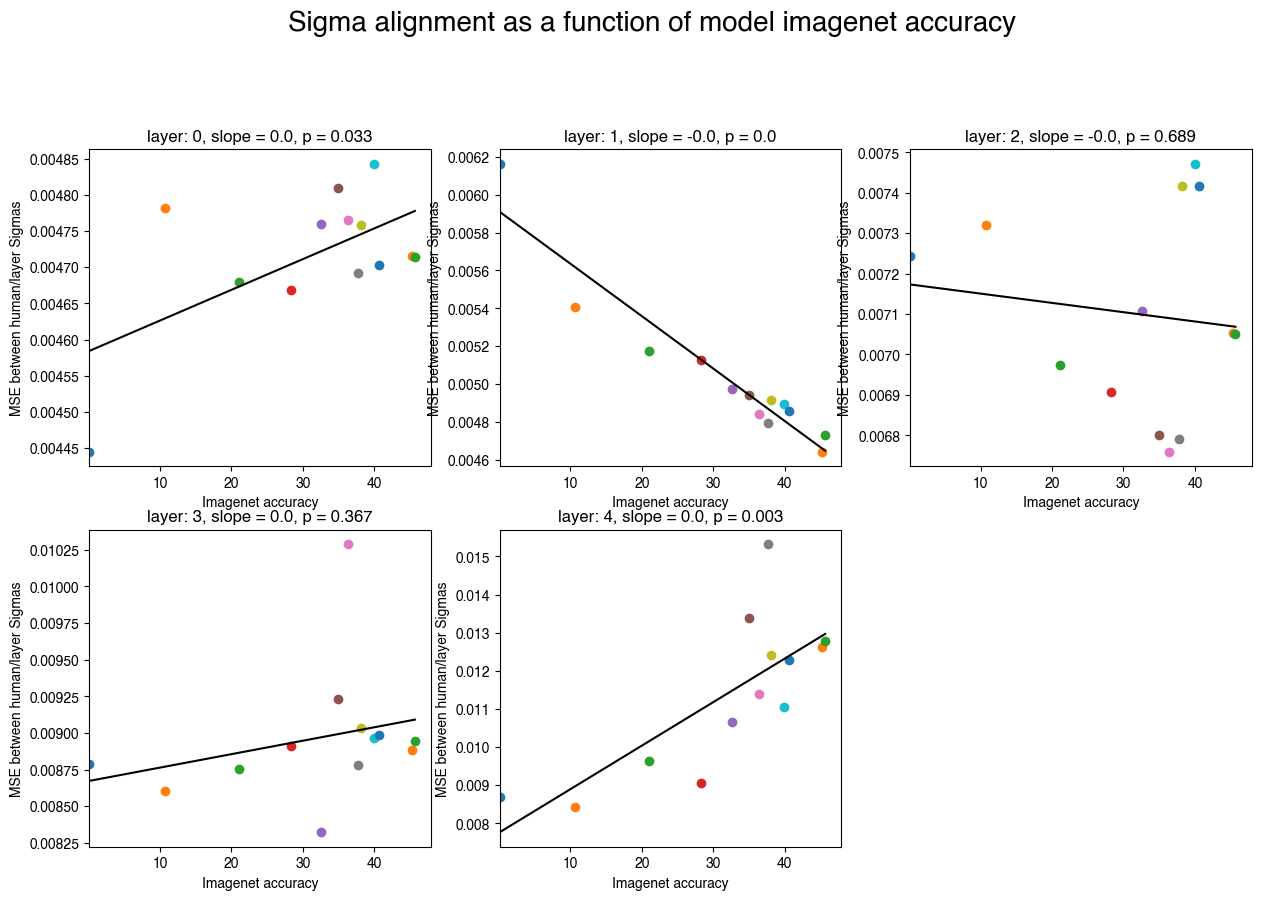

In [66]:
plt.figure(figsize = (15,14))
#plot for each layer
for layer in layers:
    plt.subplot(3,3,layer+1)
    x = []
    y = []
    #plot every model corr and imagenet accuracy
    for i in range(0,len(model_names)):
        #get values
        INperformance = allINacc[model_names[i]];
        modelLayerCorr = allCorrs[i][layer]
        if INperformance != 'NaN':
        #plot and save into array
            plt.scatter(INperformance, modelLayerCorr)
            x.append(INperformance), y.append(modelLayerCorr)
        
    #get usable values, set limits    
    plt.xlim(min(x)*.95, max(x)*1.05)
    #plt.ylim([min(y)*.95, max(y)*1.05])
    plt.xlabel('Imagenet accuracy')
    plt.ylabel('MSE between human/layer Sigmas')
    
    # plot regression line, get pvalue
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    
    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
    
plt.suptitle('Sigma alignment as a function of model imagenet accuracy', fontsize=20);
plt.show()

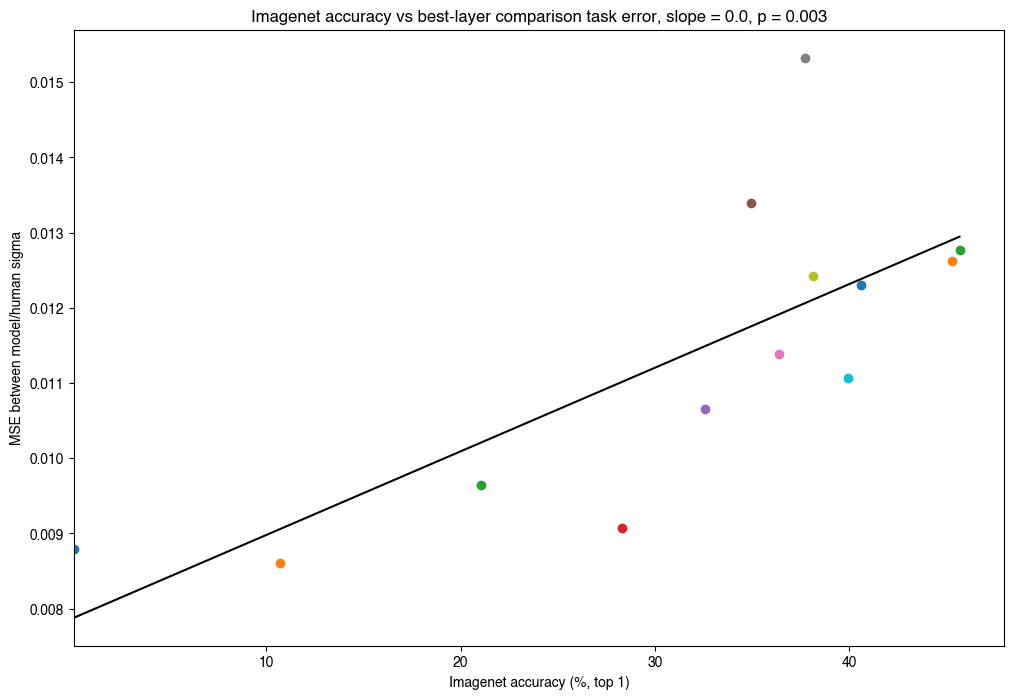

In [67]:
plt.figure(figsize = (12,8))
#plot for each layer
x = []
y = []
#plot every model corr and imagenet accuracy
for i in range(0,len(model_names)):
    #get values
    INperformance = allINacc[model_names[i]];
    modelLayerCorr = max(allCorrs[i])
    if INperformance != 'NaN':
        #plot and save into array
        plt.scatter(INperformance, modelLayerCorr)
        x.append(INperformance), y.append(modelLayerCorr)

#get usable values, set limits    
plt.xlim(min(x)*.95, max(x)*1.05)
#plt.ylim([min(y)*.90, max(y)*1.05])
plt.xlabel('Imagenet accuracy (%, top 1)')
plt.ylabel('MSE between model/human sigma')
plt.title('Imagenet accuracy vs best-layer comparison sigma alignment')

#plot the best fit line
plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black');
#plt.plot([np.min(x),np.max(x)], [sum(humanNullMSEindividualTex.values()), sum(humanNullMSEindividualTex.values())],  'black', linestyle='dashed', label='Human-chance floor');
res = scipy.stats.linregress(x,y)
plt.title('Imagenet accuracy vs best-layer comparison task error' + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)));
plt.show()

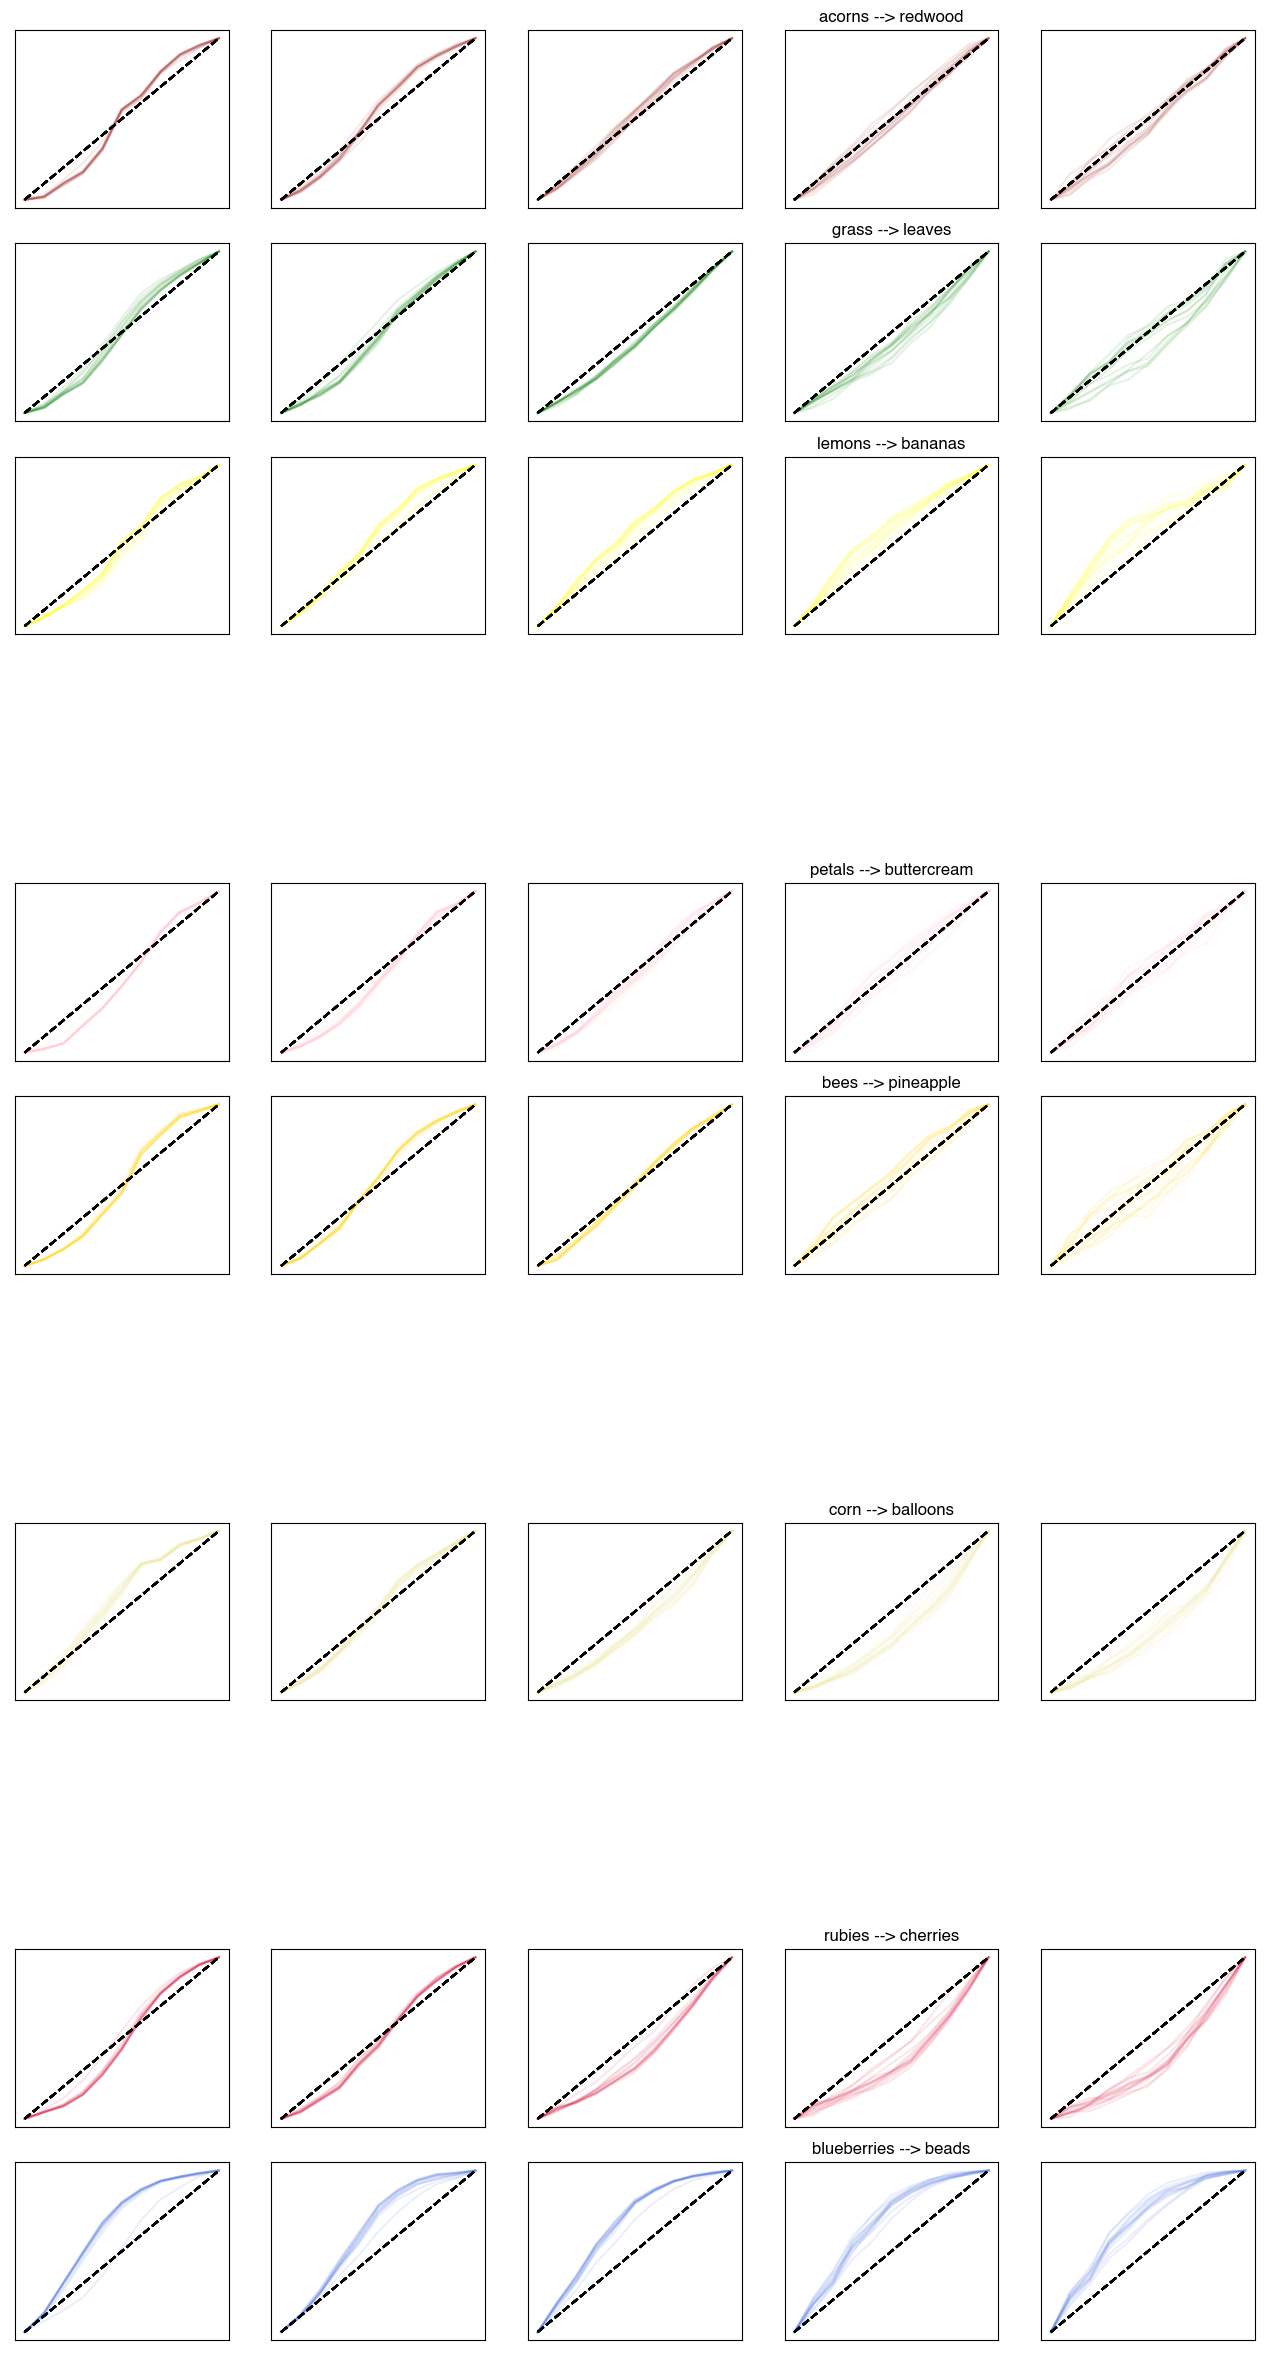

In [68]:
plt.figure(figsize=(16, 30))
for model_name in model_names:
    for layer in layers:
        for tex in texIndices:
            plt.subplot(max(texIndices)+1, max(layers)+1, tex*len(layers) + layer+1)
            plt.plot(interpValues, Psis[model_name][layer, tex], color = colors[tex], alpha = .1)
            plt.plot([0,1], [0, 1], 'black', linestyle = 'dashed')
            plt.xticks([]), plt.yticks([])
            if layer == 3:
                plt.title(image1Names[tex] + ' --> ' + image2Names[tex])
plt.show()

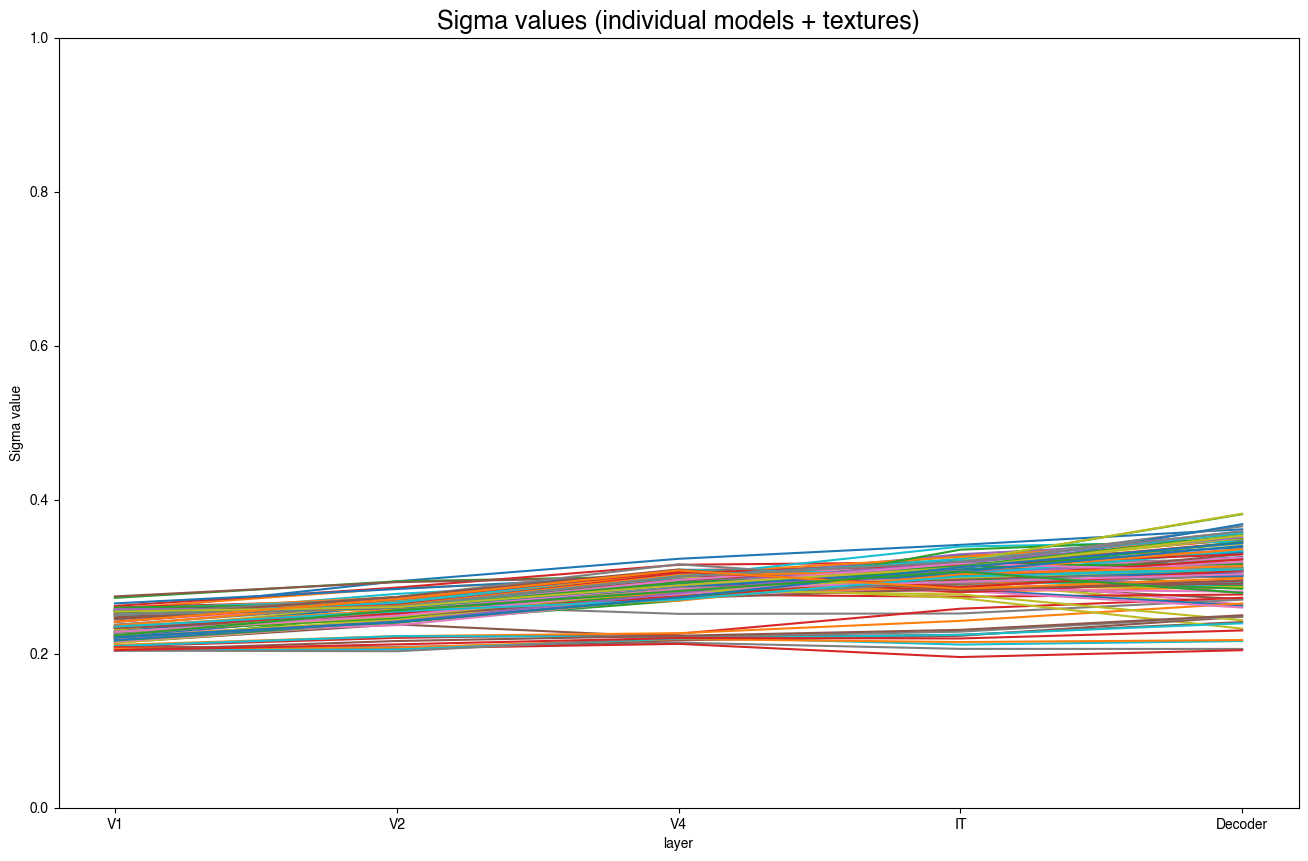

In [74]:
plt.figure(figsize=(16, 10))
for model_name in model_names:
    for tex in texIndices:
        sigmaValues = [];
        for layer in layers:
            sigmaValues.append(NNsigmas[model_name][layer, tex])
            
        plt.plot(layers, sigmaValues)
        
plt.ylim([0, 1])
    
            
plt.xlabel('layer');
plt.ylabel('Sigma value')
plt.xticks(range(0,len(MSE[model_name])), layerNames);
plt.title('Sigma values (individual models + textures)', fontsize=18)            
plt.show()



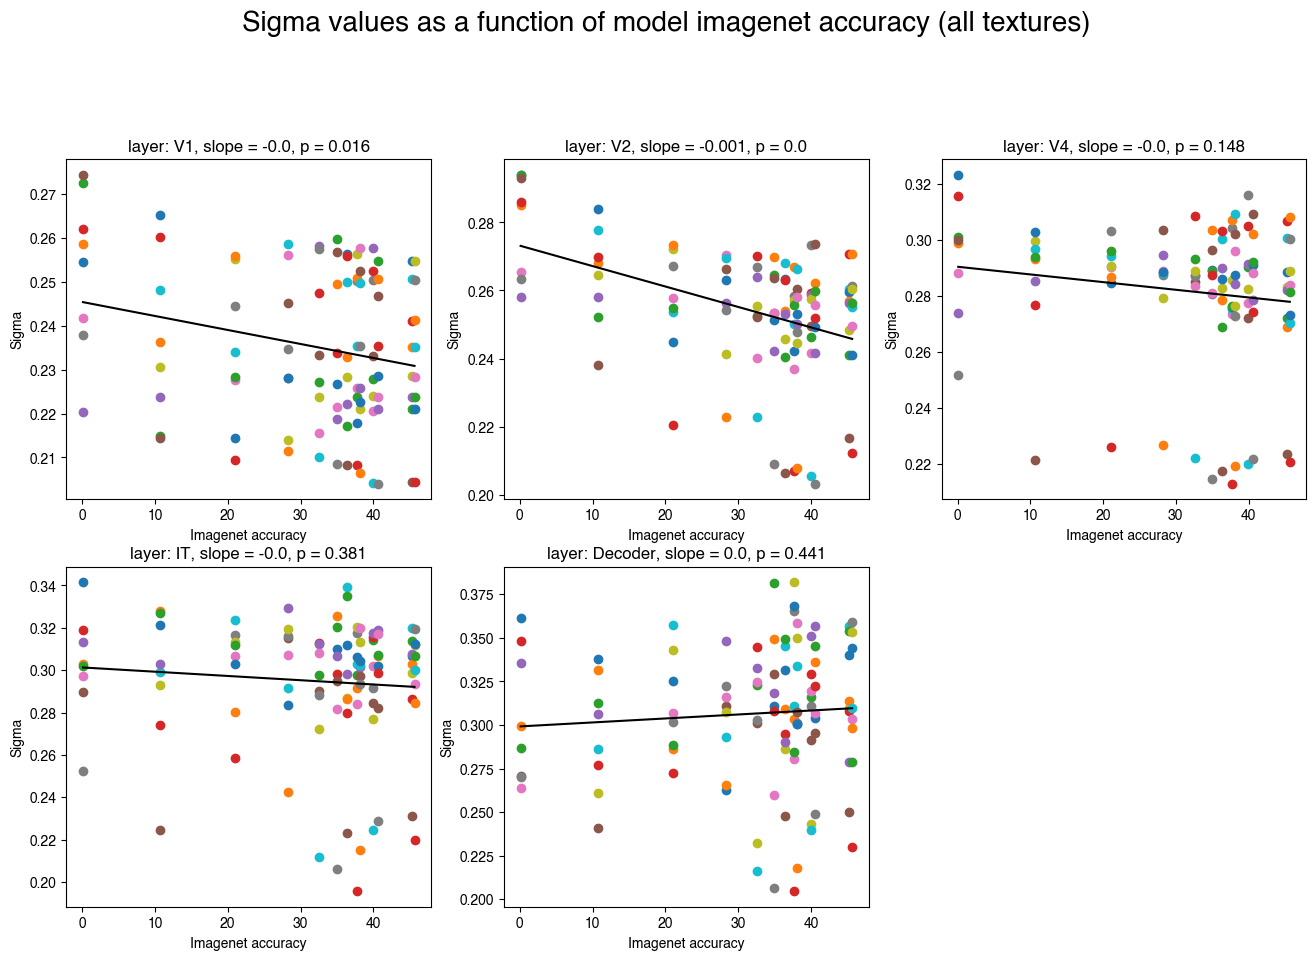

In [75]:
plt.figure(figsize=(16, 15))
for layer in layers:
    x = [];
    y = [];
    
    for model_name in model_names:    
        plt.subplot(3,3,layer+1)
        for tex in texIndices:
            INperformance = allINacc[model_name]
            sigma = NNsigmas[model_name][layer, tex];
            if INperformance != 'NaN':
                plt.scatter(INperformance, sigma)
                x.append(INperformance), y.append(sigma)
    
    #get usable values, set limits    
    #plt.xlim(min(x)*.95, max(x)*1.05)
    #plt.ylim([min(y)*.95, max(y)*1.05])
    plt.xlabel('Imagenet accuracy')
    plt.ylabel('Sigma')
            
    # plot regression line, get pvalue
    res = scipy.stats.linregress(x,y)
    plt.title('layer: ' + layerNames[layer] + ', slope = ' + str(round(res.slope,3)) +  ', p = ' + str(round(res.pvalue,3)))

    #plot the best fit line
    plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')
            
plt.suptitle('Sigma values as a function of model imagenet accuracy (all textures)', fontsize=20);
plt.show()


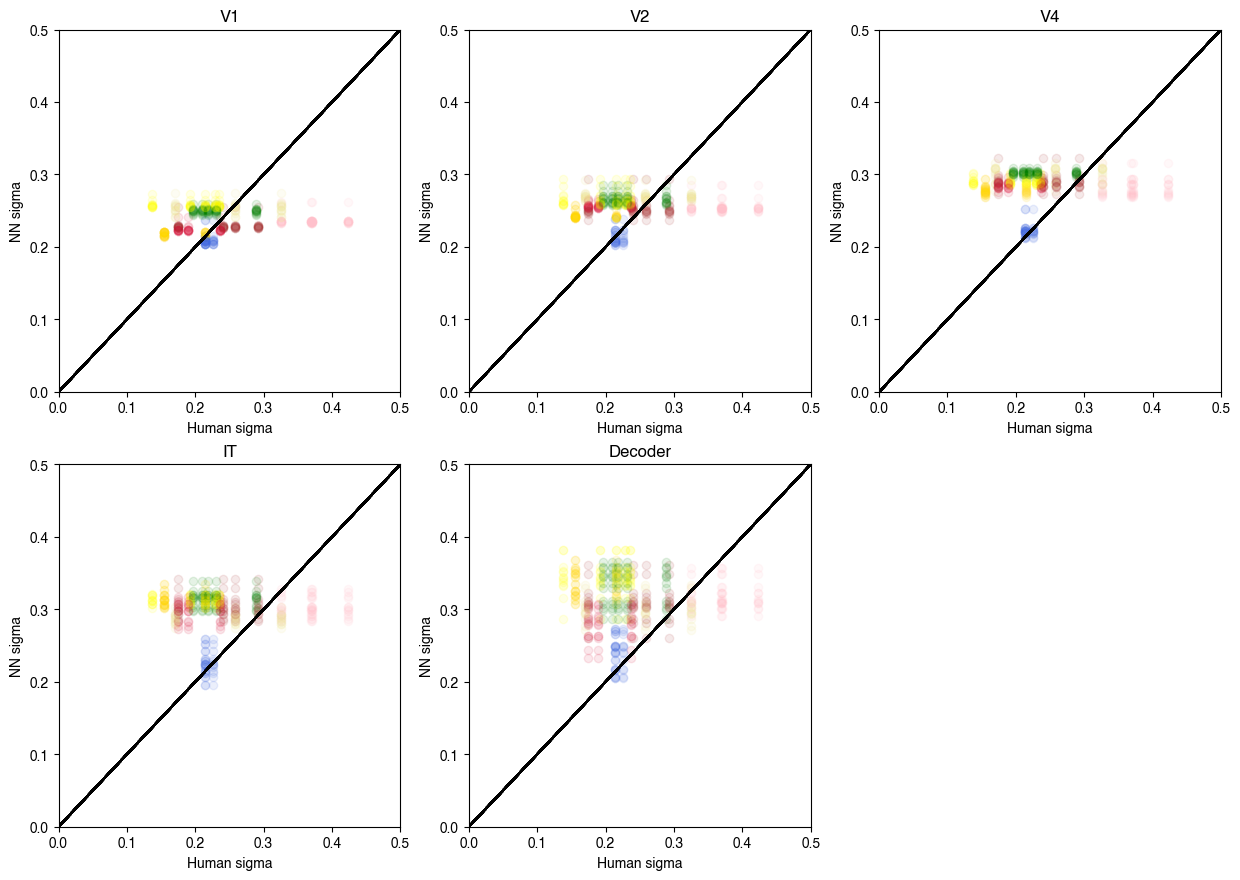

In [76]:
plt.figure(figsize = (15,16))
for layer in layers:
    plt.subplot(3,3, layer+1)
    x = [];
    y = [];
    for model in model_names:
        for tex in texIndices:
            for subject in range(0,len(PPdata.gaussSigma)):
                if len(PPdata.gaussSigma[subject]) > tex:
                    if PPdata.gaussSigma[subject][tex]:
                        plt.scatter(PPdata.gaussSigma[subject][tex], NNsigmas[model][layer,tex], color = colors[tex], alpha = .1)
                        x.append(PPdata.gaussSigma[subject][tex]); y.append(NNsigmas[model][layer,tex]);
            plt.xlim([0, .5]); plt.ylim([0,.5])
            plt.plot([0, 1], [0,1], color = 'black')
    
    plt.title(layerNames[layer])
    plt.xlabel('Human sigma')
    plt.ylabel('NN sigma')
    
    #scipy.stats.ttest_rel(x,y)
plt.show()
        

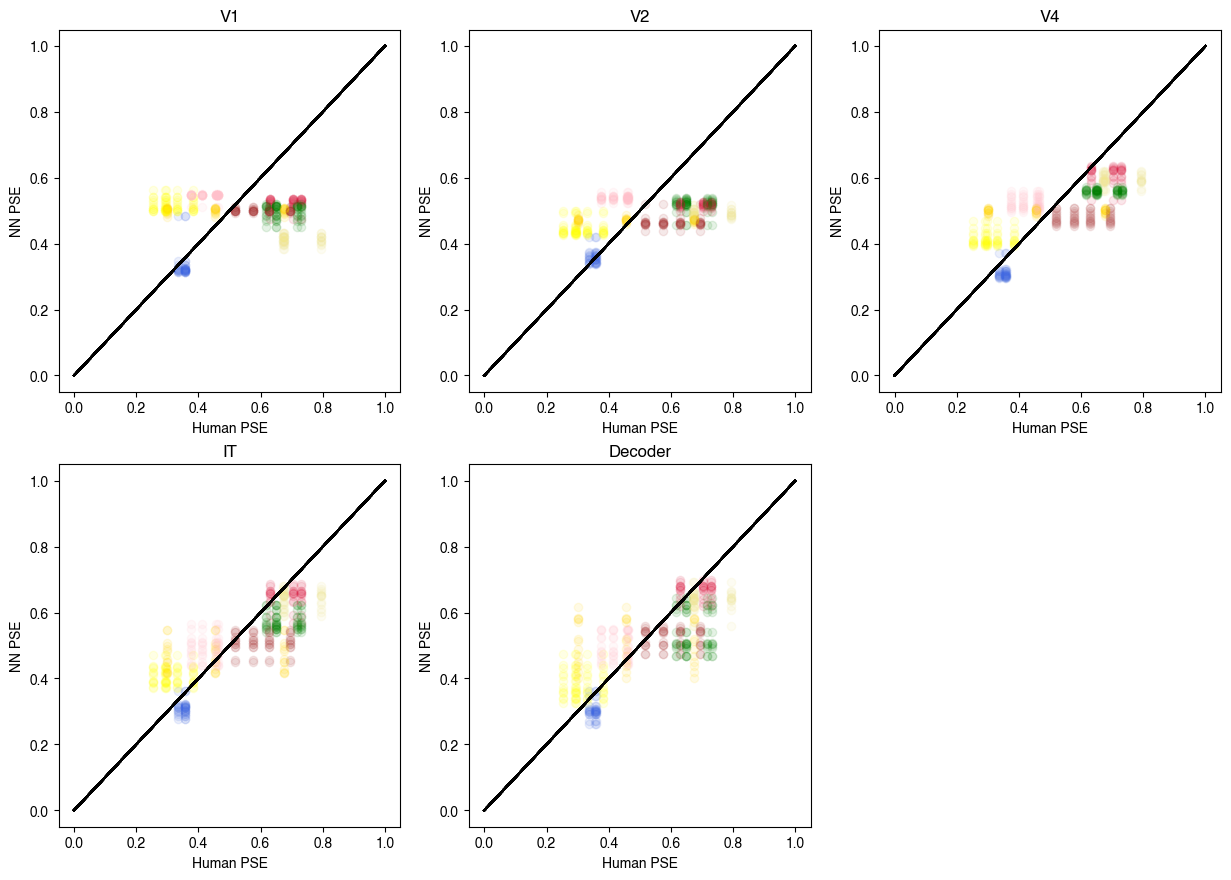

In [77]:
plt.figure(figsize = (15,16))
for layer in layers:
    plt.subplot(3,3, layer+1)
    x = [];
    y = [];
    for model in model_names:
        for tex in texIndices:
            for subject in range(0,len(PPdata.gaussSigma)):
                if len(PPdata.PSE[subject]) > tex:
                    if PPdata.PSE[subject][tex]:
                        plt.scatter(PPdata.PSE[subject][tex], NNmus[model][layer,tex], color = colors[tex], alpha = .1)
                        x.append(PPdata.PSE[subject][tex]); y.append(NNmus[model][layer,tex]);
            #plt.xlim([0, .5]); plt.ylim([0,.5])
            plt.plot([0, 1], [0,1], color = 'black')
    
    plt.title(layerNames[layer])
    plt.xlabel('Human PSE')
    plt.ylabel('NN PSE')
    
    #scipy.stats.ttest_rel(x,y)
plt.show()
        

In [78]:
plt.figure(figsize=[7,4])
ax = plt.gca()
x = [];
y = [];
for model in model_names:
    layer = np.argmin(allMSE[np.where(model_names == model)])
    for tex in texIndices:
        for subject in range(0,len(PPdata.gaussSigma)):
            if len(PPdata.PSE[subject]) > tex:
                if PPdata.PSE[subject][tex]:
                    plt.scatter(PPdata.PSE[subject][tex], NNmus[model][layer,tex], color = colors[tex], alpha = .1)
                    x.append(PPdata.PSE[subject][tex]); y.append(NNmus[model][layer,tex]);
        
plt.plot([.25, .75], [.25,.75], color = 'black', linestyle = 'dashed')

plt.title('Human and neural network biases (best fit layer)')
plt.xlabel('Human bias (PSE)')
plt.ylabel('NN bias (PSE)')

plt.xlim([.15, .85]); plt.ylim([.15, .85])

plt.plot(x, np.poly1d(np.polyfit(x, y, 1))(x), color='black')

utils.draw_publish_axis(ax, xrange = [.2, .8], yrange = [.2, .8], xticks = [.2, .5, .8], yticks = [.2, .5, .8])
plt.show()
#plt.savefig(os.path.expanduser('~/Library/CloudStorage/OneDrive-Stanford/geometry/balvenie_figs/fig4.svg'), format = 'svg')

ValueError: attempt to get argmin of an empty sequence